In [2]:
import os
import gsw
import datetime
import numpy as np
import numpy as np
import pandas as pd
import seawater as sw
#import cmocean.cm as cmo
import matplotlib.pyplot as plt

/var/folders/n4/nk6k_c65111dd1zq088dqpb40000gn/T/ipykernel_1184/3480337663.py:7: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [3]:
print(os.getcwd())
new_folder = "/Users/sydneyperkins/miniconda3/envs/heatfluxcode/code_files"
os.chdir(new_folder)
print("Current directory set to:", os.getcwd())

/Users/sydneyperkins/miniconda3/envs/heatfluxcode/code_files
Current directory set to: /Users/sydneyperkins/miniconda3/envs/heatfluxcode/code_files


In [4]:
from glob import glob
from scipy.io import loadmat
#from pymatreader import read_mat
from mpl_toolkits import mplot3d
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from scipy.ndimage import gaussian_filter1d as gfilter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
mat_data = loadmat('/Users/sydneyperkins/Downloads/ASTRAL_DBASIS_upper_CTDgrid.mat')
key = list(mat_data.keys())[-1]
data = mat_data[key][0]
time = data['std_profiles'][0]['time'][0][0].squeeze()
time = time[2:] # Removing areas with no data in the vector\n",
time = pd.to_datetime(time-719529, unit='D') # transforming the matlab time format (datenum) to the python time format (datetime)
time = np.delete(time,[927, 3780, 3781], 0) #deleting bad profiles
depth = data['std_profiles'][0]['P'][0][0];
depth = depth[20:381,2:] # Removing areas with no data
depth = np.delete(depth,[927, 3780, 3781], 1) #deleting bad profiles
vmin, vmax = np.round(np.nanmin(depth),2), np.round(np.nanmax(depth),2)
delta = .25
depth = np.arange(vmin, vmax + delta, delta) #recreating a depth vector that makes sense
time, depth = np.meshgrid(time, depth)
rho = data['std_profiles'][0]['rho'][0][0]; rho = rho[20:381,2:] #potential density
rho = np.delete(rho,[927, 3780, 3781], 1) #deleting bad profiles
sigma = rho-1e3
insitutemp = data['std_profiles'][0]['T'][0][0]; insitutemp = insitutemp[20:381,2:] # in-situ temperature
insitutemp = np.delete(insitutemp,[927, 3780, 3781], 1) #deleting bad profiles
SP = data['std_profiles'][0]['S'][0][0]; SP = SP[20:381,2:] #practical salinity
SP = np.delete(SP,[927, 3780, 3781], 1) #deleting bad profiles
P = data['std_profiles'][0]['P'][0][0]; P = P[20:381,2:] #Pressure
P = np.delete(P,[927, 3780, 3781], 1) #deleting bad profiles
SA = gsw.SA_from_SP(SP, depth, 85, 12) # computing absolutesalinity
temp = gsw.CT_from_t(SA, insitutemp, depth) # computing conservative temperature
gswrho = gsw.rho(SA,temp,P)
timez = time[:,1]

In [5]:
index26= []
depth26= []    #creates an empty list in python so that we can later append values into it
for i in range(temp.shape[1]):      #for all of the values in in temp.shape
    temp_profile= temp[:,i]        #making temp profile, across all depth for each time profile
    index26nonvect = np.argwhere(temp_profile > 26).argmax()    #index of each mixed layer depth
    index26.append(index26nonvect) #list of mixed layer depth
    depth26.append(depth[index26nonvect,i])
depth26=np.array(depth26)
print(depth26.shape)

(3779,)


In [6]:
firstdepthrho03= []
mldrho03 = []
for i in range(rho.shape[1]):
    matcha = np.where(~np.isnan(rho[:,i]))[0] #filters out nan across all rows (:) and across i columns
    firstdepthindex = np.where(~np.isnan(rho[:,i]))[0][0]
    firstrho03 = rho[matcha, i] #extracts non-Nan values
    mlrho03 = firstrho03[0]+.03

    indexmldrho03 = np.argmax(firstrho03 >= mlrho03)
    firstdepthrho03.append(depth[matcha[0],i])
    mldrho03.append(depth[matcha[indexmldrho03], i])

mldrho125 = []
firstdepthrho125 = []
for i in range(rho.shape[1]):
    chai = np.where(~np.isnan(rho[:,i]))[0] #
    firstrho125 = rho[chai, i]
    mlrho125 = firstrho125[0]+.125
    indexmldrho125= np.argmax(firstrho125 >= mlrho125)
    mldrho125.append(depth[chai[indexmldrho125], i])

firstdepth = depth[matcha]

firstrho03 = rho[matcha, i] #extracts non-Nan values
print(firstrho03)

In [7]:
mldrho03 =np.array(mldrho03)
mldrho125 = np.array(mldrho125)
depth26 = np.array(depth26)
timez= time[0,:]

In [8]:
Cp = gsw.cp_t_exact(SA, temp, P) #specific heat capacity
Cpmean= np.nanmean(Cp) # mean specific heat capacity

In [9]:
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import trapezoid, simpson
eq= rho*temp 
integrated_values_simps = simpson(eq, depth, axis=0) #needed for ocean heat quantity 

In [11]:
# heat_total= integrated_values*(Cpmean/1)#/depth26)
# heat_bottom_125 = integratednew_values*(Cpmean/1)#(depth26-mldrho125))
# heat_top_125 = integratedtoptomld_values*(Cpmean/1)#(mldrho125))

In [12]:
depth0= depth26-(depth[firstdepthindex,1])
deno0 = (Cpmean/depth0)
depth1_125 = mldrho125-(depth[firstdepthindex,1])
deno1_125 = (Cpmean/depth1_125)
depth2_125 = depth26-mldrho125
deno2_125 = (Cpmean/depth2_125)
t = pd.date_range(
    start='2024-05-19T02:30:00',
    end='2024-06-09T05:07:00',
periods=3779)

depth0= depth26-(depth[firstdepthindex,1])
deno0 = (Cpmean/depth0)
depth1_03 = mldrho03-(depth[firstdepthindex,1])
deno1_03 = (Cpmean/depth1_03)
depth2_03 = depth26-mldrho03
deno2_03 = (Cpmean/depth2_03)

In [13]:
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import simpson
Ktemp = temp + 273
rho26 = rho[index26, :]
rho26mean = np.nanmean(rho26)
#rhoxtemp = (Ktemp-26)*rho
Cpxrhomean = Cpmean * rho26mean
rhoxtemp = (Ktemp-(26+273))

In [14]:
#CALCULATING TOTAL HEAT (TOP TO 26 ISOLINE)
integrated_values = np.zeros(temp.shape[1]) #idk what this does it just fixes issues

for i in range(temp.shape[1]):
    xvaluestot = depth[0:index26[i],i]
    data_subsettot = rhoxtemp[0:index26[i], i]
    integrated_value = simpson(data_subsettot, xvaluestot, axis=0)
    integrated_values[i] = integrated_value
print(integrated_value)

integratednew_values = np.zeros(temp.shape[1]) #idk what this does it just fixes issues
#CLACULATING HEAT FROM MLD TO 26 ISOLINE
for i in range(temp.shape[1]):
    xvalues26 = depth[0:index26[i],i]
    xvaluesmldrho26125 = depth[indexmldrho125:index26[i],i]
    data_subsetmldrho26125 = rhoxtemp[indexmldrho125:index26[i],i]
    integratednew_value= simpson(data_subsetmldrho26125, xvaluesmldrho26125, axis=0)
    integratednew_values[i] = integratednew_value

#Calculating from the top to the mld

integratedtoptomld_values = np.zeros(temp.shape[1]) #idk what this does it just fixes issues
for i in range(temp.shape[1]):
    xvaluesmldrho125 = depth[0:indexmldrho125,i]
    data_subsetmldrho125 = rhoxtemp[0:indexmldrho125, i]
    integratedtoptomld_value= simpson(data_subsetmldrho125,
    xvaluesmldrho125, axis=0)
    integratedtoptomld_values[i] = integratedtoptomld_value

heat_total = integrated_values*Cpxrhomean#/depth0
heat_bottom_125 = integratednew_values*Cpxrhomean#/depth1_125
heat_top_125 = integratedtoptomld_values*Cpxrhomean#/depth2_125
print(heat_bottom_125)

265.5381393298412
[4.09281675e+08 4.59677459e+08 4.10196770e+08 ... 3.02907661e+08
 2.95712589e+08 2.99481614e+08]


In [15]:
#calculating from the mld to the 26 mark for mld 03

integratednew03_values= np.zeros(temp.shape[1]) #idk what this does it just fixes issues

for i in range(temp.shape[1]):
    temp_profile= temp[:,i]
    xvaluesmldrho2603 = depth[indexmldrho03:index26[i],i]
    data_subsetmldrho2603 = rhoxtemp[indexmldrho03:index26[i],i]
    integratednew03_value= simpson(data_subsetmldrho2603, xvaluesmldrho2603, axis=0)
    integratednew03_values[i] = integratednew03_value

#Calculating from the top to the mld
integratedtop03_values= np.zeros(temp.shape[1]) #idk what this does it just fixes issues
for i in range(temp.shape[1]):
    indexmldrho03 = np.argmax(firstrho03 >= mlrho03)
    xvaluesmldrho03 = depth[0:indexmldrho03,i]
    data_subsetmldrho03 = rhoxtemp[0:indexmldrho03, i]
    integratedtop03_value= simpson(data_subsetmldrho03,
    xvaluesmldrho03, axis=0)
    integratedtop03_values[i] = integratedtop03_value

heat_bottom_03 = integratednew03_values*(Cpxrhomean/1)#/depth1_03
heat_top_03 = integratedtop03_values*(Cpxrhomean/1)#/depth2_03

In [16]:
#MAKING HEAT INTO XARRAYS
import xarray as xr
heattotalxr = xr.DataArray(heat_total, coords=[timez], dims=['time']) #turning heat content into xarray arrays
heattop125xr = xr.DataArray(heat_top_125, coords=[timez], dims=['time'])
heatbottom125xr = xr.DataArray(heat_bottom_125, coords=[timez], dims=['time'])

#INTERPOLATING HEAT 
interp_time = pd.date_range('2024-05-19T02:30:00',
'2024-06-09T05:07:00', freq='10s')
heat_total_xr= heattotalxr.interp(time=t)
heat_top_125_xr = heattop125xr.interp(time=t)
heat_bottom_125_xr = heatbottom125xr.interp(time=t)

#TAKING THE ROLLING AVERAGE
heat_total_roll= heat_total_xr.rolling(time=170, min_periods=1, center=True).mean() 
#daily mean (140= 3779/22 days), with it starting at 1, and is centered on the day
heat_top_125_roll = heat_top_125_xr.rolling(time=170, min_periods=1,center=True).mean()
heat_bottom_125_roll = heat_bottom_125_xr.rolling(time=170, min_periods=1,center=True).mean()

#TAKING GRADIENT OF THE ROLLING MEAN OF THE TOTAL HEAT
heat_total_125_RG = heat_total_roll.differentiate('time', datetime_unit = 's')
heat_top_125_RG = heat_top_125_roll.differentiate('time', datetime_unit = 's')
heat_bottom_125_RG = heat_bottom_125_roll.differentiate('time', datetime_unit = 's')


In [17]:
#TAKING THE HEAT BY DEPTH
heatbydepthtotalx = heat_total_xr/(depth0)
heatbydepthto125x= heat_top_125_xr/(depth1_125)
heatbydepthbottom125x= heat_bottom_125_xr/(depth2_125)

#TAKING THE ROLLING MEAN OF HEAT BY DEPTH
#daily mean (140= 3779/22 days), with it starting at 1, and is centered on the day
heatbydepth_total_roll= heatbydepthtotalx.rolling(time=170, min_periods=1, center=True).mean() 
heatbydepth_top_125_roll = heatbydepthto125x.rolling(time=170, min_periods=1, center=True).mean()
heatbydepth_bottom_125_roll = heatbydepthbottom125x.rolling(time=170, min_periods=1, center=True).mean()

#TAKING GRADIENT OF THE ROLLING MEAN OF HEAT BY DEPTH
heatbydepth_total_125_RG = heatbydepth_total_roll.differentiate('time', datetime_unit = 's') #RG = rolling gradient
heatbydepth_top_125_RG = heatbydepth_top_125_roll.differentiate('time', datetime_unit = 's')
heatbydepth_bottom_125_RG = heatbydepth_bottom_125_roll.differentiate('time', datetime_unit = 's')

# heatbydepthtot125xni = xr.DataArray(heatbydepthtot125, coords=[timez], dims=['time']) #turning heat content into xarray arrays
# heattot125xni = xr.DataArray(heattot125, coords=[timez], dims=['time']) #turning heat content into xarray arrays
# heattot125xni = xr.DataArray(heattot125, coords=[timez], dims=['time']) #turning heat content into xarray arrays

In [18]:
#MAKING DATES FOR PLOTS
dates1 = pd.date_range(start='2024-05-19', end='2024-05-23')#setting dates for each condition/
dates2 = pd.date_range(start='2024-05-23', end='2024-05-28')
dates3 = pd.date_range(start='2024-05-28', end='2024-06-04')
dates4 = pd.date_range(start='2024-06-04', end='2024-06-09 06:15', freq = 'min')

In [53]:
#SAVING FIGURES CODE
def save_fig(filename, fig=None):
    if fig is None:
        fig = plt.gcf()  # Get current figure
    current_directory = ('/Users/sydneyperkins/miniconda3/envs/heatfluxcode/code_files/images')
    file_path = os.path.join(current_directory, filename)
    fig.savefig(file_path)

<function matplotlib.pyplot.show(close=None, block=None)>

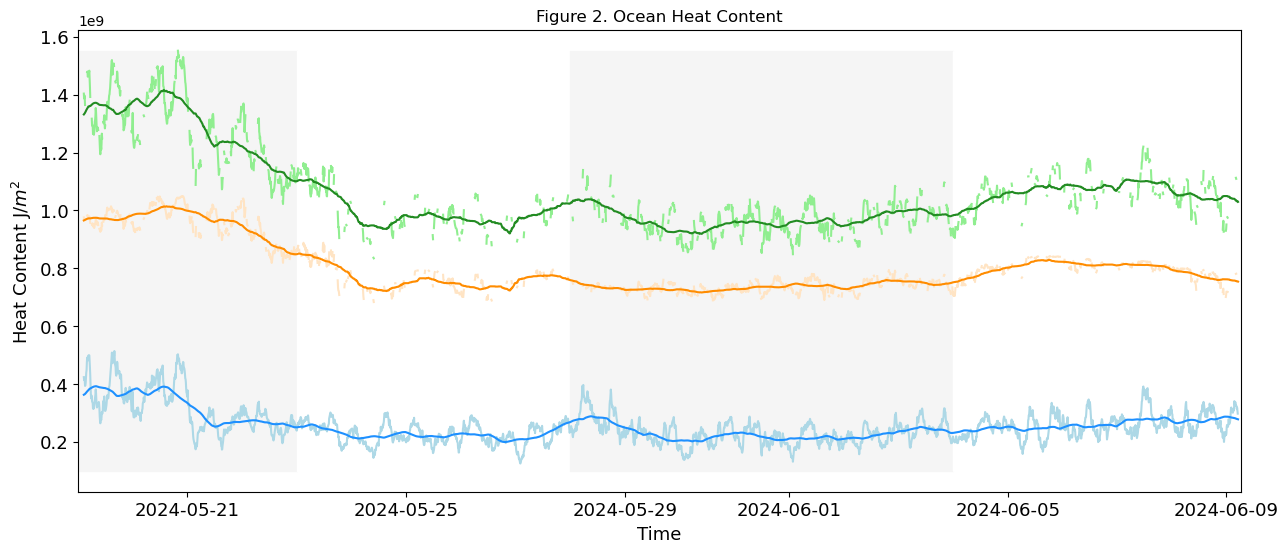

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(heat_total_xr['time'], heat_total_roll, color = 'forestgreen', label = 'Ocean Heat Content Rolling Average (24H Interval)', zorder = 5)
plt.plot(heat_total_xr['time'], heat_total_xr, color = 'lightgreen', label = 'Ocean Heat Content')
plt.plot(heat_total_xr['time'], heat_top_125_roll, color = 'darkorange', label = 'Mixed Layer Rolling Average (24H Interval)', zorder = 5)
plt.plot(heat_total_xr['time'], heat_top_125_xr, color = 'bisque', label = 'Mixed Layer')
plt.plot(heat_total_xr['time'], heat_bottom_125_roll, color = 'dodgerblue', label = 'Bottom Layer Rolling Average', zorder = 5)
plt.plot(heat_total_xr['time'], heat_bottom_125_xr, color = 'lightblue', label = 'Bottom Layer')
plt.fill_between(dates1, 1.55e9,0.1e9, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None)
plt.fill_between(dates2, 1.55e9,0.1e9, where=None, interpolate=False, color= 'white', step=None , data=None )
plt.fill_between(dates3, 1.55e9,0.1e9, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None )
plt.fill_between(dates4, 1.55e9,0.1e9, where=None, interpolate=False, color= 'white', step=None, data=None)
plt.title('Figure 2. Ocean Heat Content')
# plt.legend()#(bbox_to_anchor=(1, 1.015), loc='upper left')
plt.xlim([datetime.date(2024, 5, 19), datetime.datetime(2024, 6, 9, 6,15)])
#plt.ylim(0.1e9,1.55e9)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Heat Content J/$m^2$', fontsize = 13)
plt.show

In [34]:
heat_dataset_125 = xr.Dataset({
    "total_heat": heat_total_xr,
    "heat_top": heat_top_125_xr,
    "heat_bottom": heat_bottom_125_xr,
    "heat_total_roll": heat_total_roll,
    "heat_top_roll": heat_top_125_roll,
    "heat_bottom_roll": heat_bottom_125_roll,
    "heat_total_grad": heat_total_125_RG,
    "heat_top_grad": heat_top_125_RG,
    "heat_bottom_grad": heat_bottom_125_RG,
    "heatbydepth_total": heatbydepthtotalx,
    "heatbydepth_top": heatbydepthto125x,
    "heatbydepth_bottom": heatbydepthbottom125x,
    "heatbydepth_total_roll": heatbydepth_total_roll,
    "heatbydepth_top_roll": heatbydepth_top_125_roll,
    "heatbydepth_bottom_roll": heatbydepth_bottom_125_roll,
    "heatbydepth_total_grad": heatbydepth_total_125_RG,
    "heatbydepth_top_grad": heatbydepth_top_125_RG,
    "heatbydepth_bottom_grad": heatbydepth_bottom_125_RG
})

In [35]:
# SAVING HEAT DATA TO NETCDF FILE
#os.path.join("/Users/sydperkins/Desktop/python2/HeatDataSet.nc")
directory_path = ("/Users/sydneyperkins/miniconda3/envs/heatfluxcode/code_files/HeatDataSet125.nc") #making directory
encoding = {
    "time": {"units": "seconds since 1970-01-01", "dtype": "float64"}
} #(did not happen in summer) netCDF did not want to accept the nano-seconds so converting time into seconds
heat_dataset_125.to_netcdf(directory_path, mode='w', encoding=encoding) #saving it

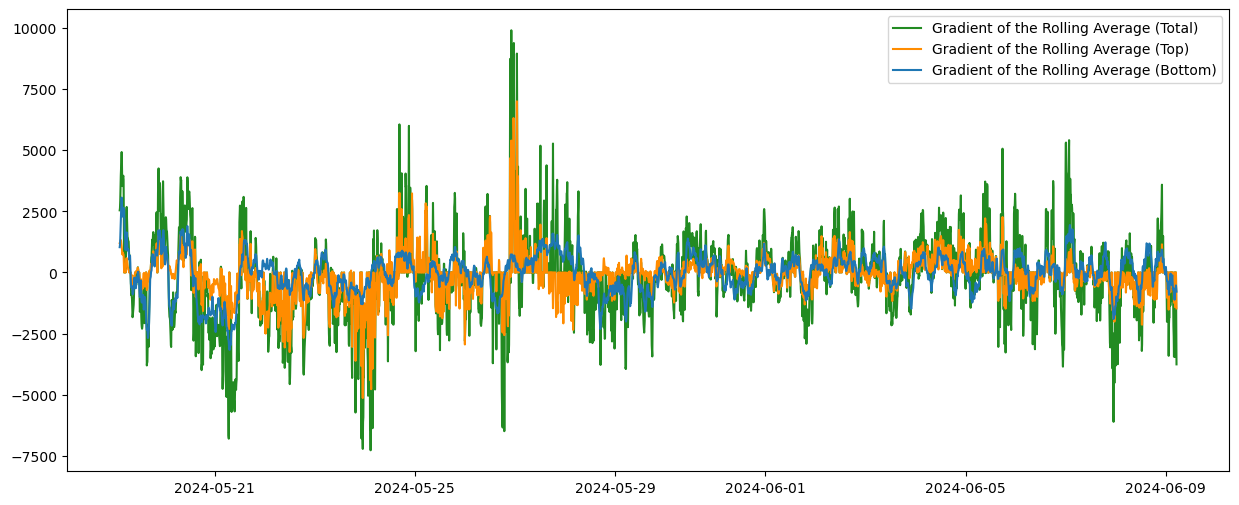

In [36]:
plt.figure(figsize=(15, 6))
plt.plot(heat_total_125_RG['time'], heat_total_125_RG, color = 'forestgreen', label = 'Gradient of the Rolling Average (Total)')
plt.plot(heat_total_125_RG['time'], heat_top_125_RG, color = 'darkorange', label = 'Gradient of the Rolling Average (Top)')
plt.plot(heat_total_125_RG['time'], heat_bottom_125_RG, color = 'tab:blue', label = 'Gradient of the Rolling Average (Bottom)')
plt.legend()
#heattotgradient125

#importing surface heat flux data ni= not interpolated
#heatfluxdatani= xr.open_dataset("/Users/sydperkins/Desktop/python2/HeatFluxDBASIS.nc")

Text(0.5, 1.0, 'Figure 4. Ocean and Surface Heat Flux')

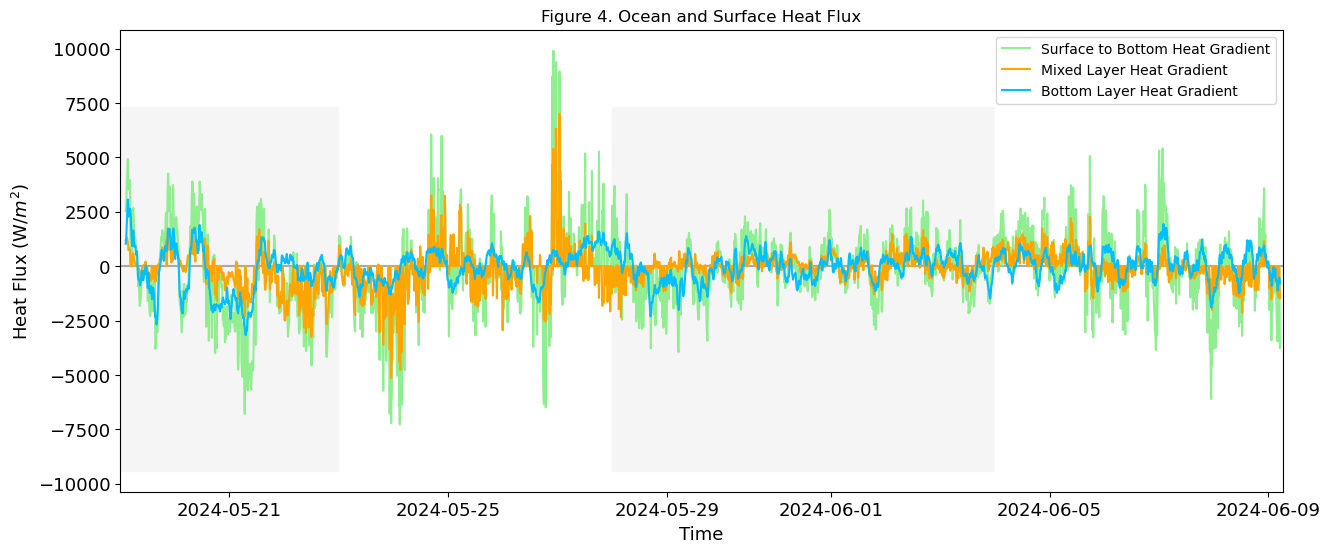

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(heat_total_125_RG['time'], heat_total_125_RG, color = 'lightgreen', 
         label = 'Surface to Bottom Heat Gradient', zorder = 5)
plt.plot(heat_total_125_RG['time'], heat_top_125_RG, color = 'orange', 
         label = 'Mixed Layer Heat Gradient', zorder = 5)
plt.plot(heat_total_125_RG['time'], heat_bottom_125_RG, color = 'deepskyblue', 
         label = 'Bottom Layer Heat Gradient', zorder = 5)
#plt.plot(heatfluxdata['time'], heatfluxdata['WW_nhf'], color = 'blueviolet', zorder = 6, label = 'Surface Flux')
# plt.axvline(datetime.datetime(2024, 5, 23), color = 'tab:pink', label = 'Premonsoon, Cyclone, Recovery, Monsoon Winds')
# plt.axvline(datetime.datetime(2024, 5, 28), color = 'tab:pink')
# plt.axvline(datetime.datetime(2024, 6, 4), color = 'tab:pink')
# plt.axvline(datetime.datetime(2024, 6, 9), color = 'tab:pink')
plt.xlim([datetime.date(2024, 5, 19), datetime.datetime(2024, 6, 9, 6,15)])
#plt.ylim(-9400, 7300)
plt.fill_between(dates1, 7300,-9400, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None, )

plt.fill_between(dates2, 7300,-9400, where=None, interpolate=False, color= 'white', step=None, data=None)
plt.fill_between(dates3, 7300,-9400, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None)
plt.fill_between(dates4, 7300,-9400, where=None, interpolate=False, color= 'white', step=None, data=None)
plt.axhline(y=0, color='darkgrey')
plt.legend()
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Time', fontsize= 13)
plt.ylabel('Heat Flux (W/$m^2$)', fontsize= 13)
plt.title('Figure 4. Ocean and Surface Heat Flux')
#plt.ylim(-6000,6000)
#plt.savefig('heatflux.png', dpi= 700)

Text(0.5, 1.0, 'Figure 4. Ocean and Surface Heat Flux')

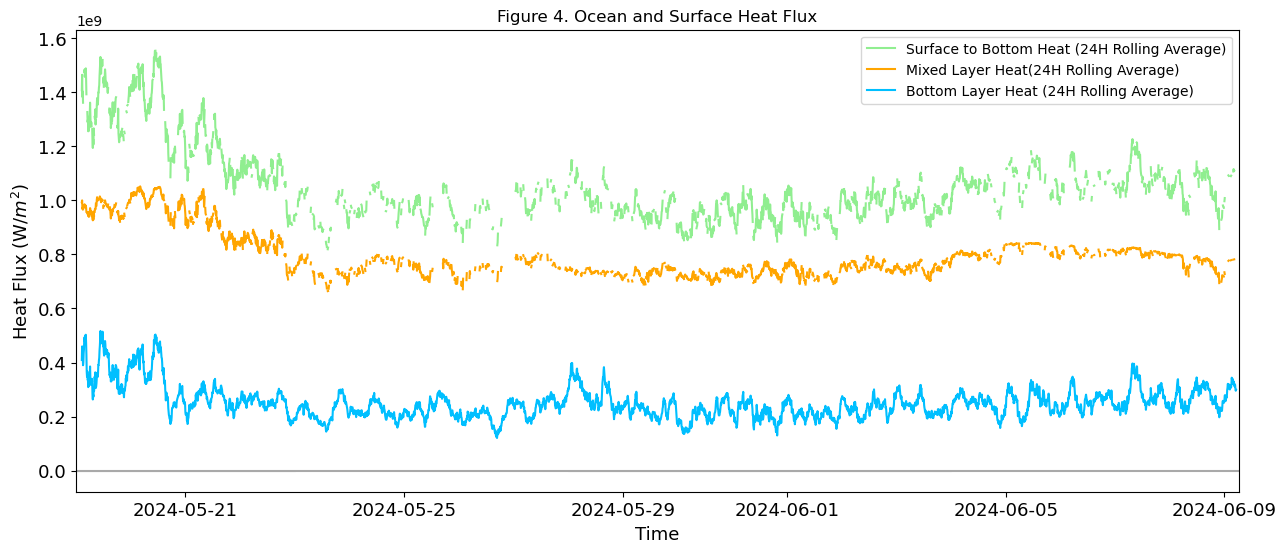

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(heat_total_125_RG['time'], heat_total, color = 'lightgreen', 
         label = 'Surface to Bottom Heat (24H Rolling Average)', zorder = 5)
plt.plot(heat_total_125_RG['time'], heat_top_125, color = 'orange', 
         label = 'Mixed Layer Heat(24H Rolling Average)', zorder = 5)
plt.plot(heat_total_125_RG['time'], heat_bottom_125, color = 'deepskyblue', 
         label = 'Bottom Layer Heat (24H Rolling Average)', zorder = 5)
#plt.plot(heatfluxdata['time'], heatfluxdata['WW_nhf'], color = 'blueviolet', zorder = 6, label = 'Surface Flux')
# plt.axvline(datetime.datetime(2024, 5, 23), color = 'tab:pink', label = 'Premonsoon, Cyclone, Recovery, Monsoon Winds')
# plt.axvline(datetime.datetime(2024, 5, 28), color = 'tab:pink')
# plt.axvline(datetime.datetime(2024, 6, 4), color = 'tab:pink')
# plt.axvline(datetime.datetime(2024, 6, 9), color = 'tab:pink')
plt.xlim([datetime.date(2024, 5, 19), datetime.datetime(2024, 6, 9, 6,15)])
#plt.ylim(-9400, 7300)
plt.fill_between(dates1, 7300,-9400, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None, )

plt.fill_between(dates2, 7300,-9400, where=None, interpolate=False, color= 'white', step=None, data=None)
plt.fill_between(dates3, 7300,-9400, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None)
plt.fill_between(dates4, 7300,-9400, where=None, interpolate=False, color= 'white', step=None, data=None)
plt.axhline(y=0, color='darkgrey')
plt.legend()
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Time', fontsize= 13)
plt.ylabel('Heat Flux (W/$m^2$)', fontsize= 13)
plt.title('Figure 4. Ocean and Surface Heat Flux')
#plt.ylim(-6000,6000)
#plt.savefig('heatflux.png', dpi= 700)

<function matplotlib.pyplot.show(close=None, block=None)>

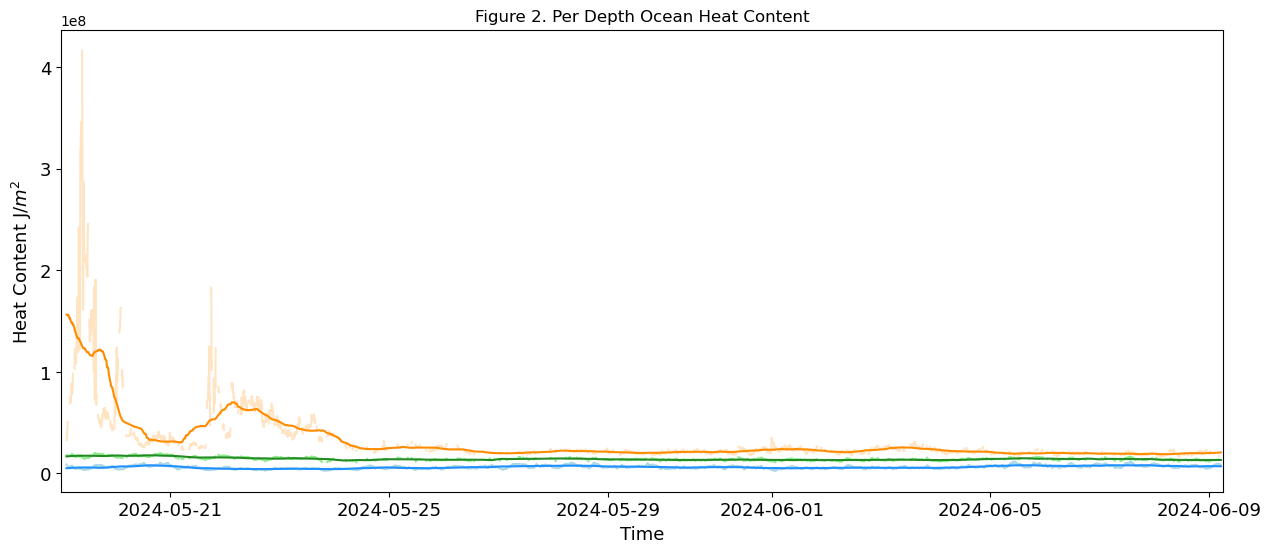

In [46]:
plt.figure(figsize=(15, 6))
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_total_roll'], color = 'forestgreen', label = 'Per Depth Ocean Heat Content Rolling Average (24H Interval)', zorder = 5)
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_total'], color = 'lightgreen', label = 'Per Depth Ocean Heat Content')
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_top_roll'], color = 'darkorange', label = 'Per Depth Mixed Layer Rolling Average (24H Interval)', zorder = 5)
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_top'], color = 'bisque', label = 'Mixed Layer')
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_bottom_roll'], color = 'dodgerblue', label = 'Bottom Layer Rolling Average', zorder = 5)
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_bottom'], color = 'lightblue', label = 'Bottom Layer')
# plt.fill_between(dates1, 1.55e9,0.1e9, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None)
# plt.fill_between(dates2, 1.55e9,0.1e9, where=None, interpolate=False, color= 'white', step=None , data=None )
# plt.fill_between(dates3, 1.55e9,0.1e9, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None )
# plt.fill_between(dates4, 1.55e9,0.1e9, where=None, interpolate=False, color= 'white', step=None, data=None)
plt.title('Figure 2. Per Depth Ocean Heat Content')
# plt.legend()#(bbox_to_anchor=(1, 1.015), loc='upper left')
plt.xlim([datetime.date(2024, 5, 19), datetime.datetime(2024, 6, 9, 6,15)])
#plt.ylim(0.1e9,1.55e9)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Heat Content J/$m^2$', fontsize = 13)
plt.show

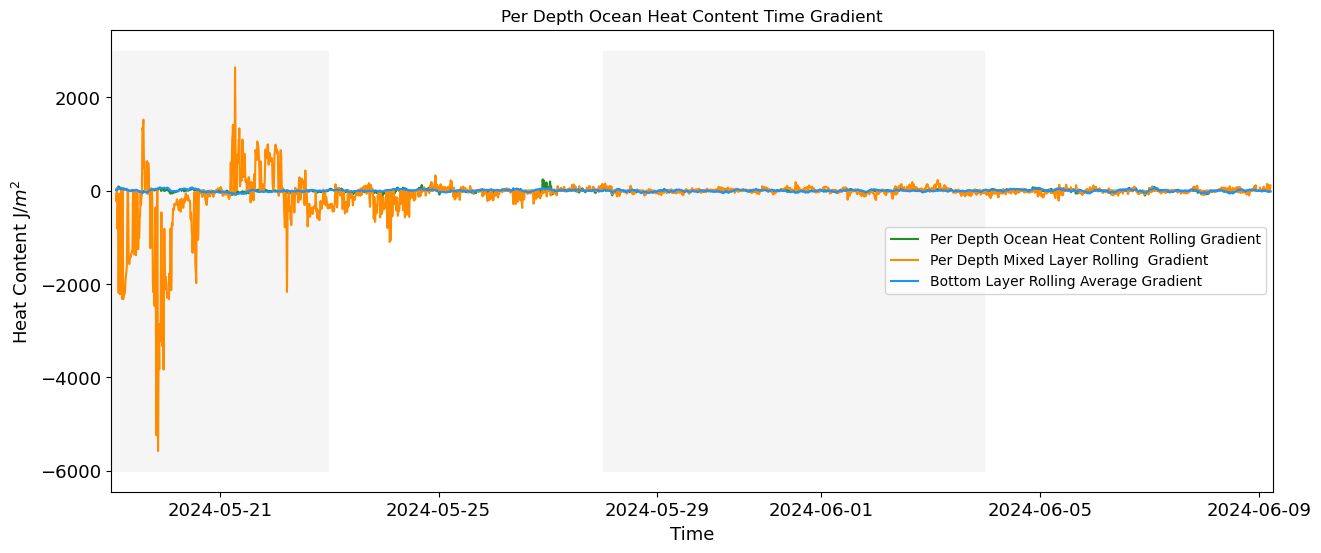

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_total_grad'], color = 'forestgreen', label = 'Per Depth Ocean Heat Content Rolling Gradient', zorder = 5)
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_top_grad'], color = 'darkorange', label = 'Per Depth Mixed Layer Rolling  Gradient', zorder = 5)
plt.plot(heat_total_xr['time'], heat_dataset_125['heatbydepth_bottom_grad'], color = 'dodgerblue', label = 'Bottom Layer Rolling Average Gradient', zorder = 5)
plt.fill_between(dates1, -6000,3000, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None)
plt.fill_between(dates2, -6000,3000, where=None, interpolate=False, color= 'white', step=None , data=None )
plt.fill_between(dates3, -6000,3000, where=None, interpolate=False, color= 'whitesmoke', step=None, data=None )
plt.fill_between(dates4, -6000,3000, where=None, interpolate=False, color= 'white', step=None, data=None)
plt.title('Per Depth Ocean Heat Content Time Gradient')
plt.legend()#(bbox_to_anchor=(1, 1.015), loc='upper left')
plt.xlim([datetime.date(2024, 5, 19), datetime.datetime(2024, 6, 9, 6,15)])
#plt.ylim(0.1e9,1.55e9)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Heat Content J/$m^2$', fontsize = 13)
plt.show
save_fig('Perdepthheatgradient125.png')